In [1]:
import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
%matplotlib inline

## Download municipality polygons and hex bins

In [2]:
#gdf = aup.gdf_from_db("mpos_2020", "marco")
mpos = ['01001','01005','01011']
mun_gdf = gpd.GeoDataFrame()
hex_bins = gpd.GeoDataFrame()
for m in mpos:
    query = f"SELECT * FROM processed.hex_bins_dist_2020 WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    hex_bins = hex_bins.append(aup.gdf_from_query(query, geometry_col='geometry'))
    query = f"SELECT * FROM marco.mpos_2020 WHERE \"CVEGEO\" LIKE \'{m}\'"
    mun_gdf = mun_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))

In [16]:
hex_bins = hex_bins.to_crs("EPSG:4326")
print(hex_bins.shape)
hex_bins.head(2)

(2088, 6)


,geometry,hex_id_8,CVEGEO,dist_farmacia,dist_hospitales,dist_supermercados
0,"POLYGON ((-102.31192 21.70346, -102.30734 21.7...",88498eae51fffff,01001,6013.5785,17233.9935,5827.3075
1,"POLYGON ((-102.54158 21.75660, -102.54209 21.7...",884988d31dfffff,01001,0.0000,0.0000,0.0000


<AxesSubplot:>

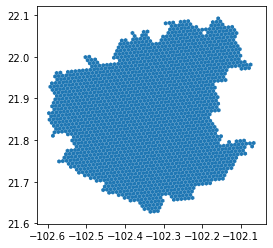

In [4]:
hex_bins.plot()

In [6]:
print(mun_gdf.shape)
mun_gdf.head(2)

(3, 5)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry
0,01001,01,001,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0..."
0,01005,01,005,Jesús María,"POLYGON ((-102.33568 22.05067, -102.33348 22.0..."


<AxesSubplot:>

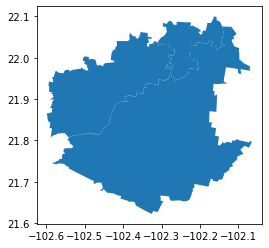

In [7]:
mun_gdf.plot()

## Download distance nodes

In [9]:
gdf_tmp = mun_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [10]:
query = f"SELECT * FROM processed.nodes_dist_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
nodes = aup.gdf_from_query(query, geometry_col='geometry')
print(nodes.shape)
nodes.head(2)

(49955, 7)


,osmid,x,y,geometry,dist_farmacia,dist_hospitales,dist_supermercados
0,272921360,-102.295073,21.872876,POINT (-102.29507 21.87288),334.213,716.149,232.373
1,272921393,-102.295097,21.871411,POINT (-102.29510 21.87141),183.576,553.205,71.637


<AxesSubplot:>

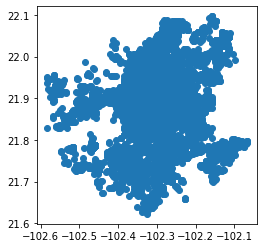

In [13]:
nodes.plot()

## Download pop nodes

In [14]:
query = f"SELECT * FROM processed.nodes_pop WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
nodes_pop = aup.gdf_from_query(query, geometry_col='geometry')
print(nodes_pop.shape)
nodes_pop.head(2)

(33921, 243)


,osmid,x,y,geometry,dist_farmacia,dist_hospitales,dist_supermercados,cve_geo,cve_ent,cve_mun,...,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic,cve_geo_ageb
0,272921360,-102.295073,21.872876,POINT (-102.29507 21.87288),334.213,716.149,232.373,0100100010854,01,001,...,7.2,5.333333,3.777778,2.2,1.222222,0.111111,0.333333,2.222222,0.0,0100100010854
1,877623027,-102.297863,21.873383,POINT (-102.29786 21.87338),0.000,1258.670,621.772,0100100010854,01,001,...,7.2,5.333333,3.777778,2.2,1.222222,0.111111,0.333333,2.222222,0.0,0100100010854


## Calculating index for nodes with distance

In [18]:
nodes_filter = nodes.loc[(nodes['dist_supermercados'] > 0) &
                        (nodes['dist_farmacia'] > 0) &
                        (nodes['dist_hospitales'] > 0)].copy()
print(nodes_filter.shape)
nodes_filter.head(2)

(49086, 7)


,osmid,x,y,geometry,dist_farmacia,dist_hospitales,dist_supermercados
0,272921360,-102.295073,21.872876,POINT (-102.29507 21.87288),334.213,716.149,232.373
1,272921393,-102.295097,21.871411,POINT (-102.29510 21.87141),183.576,553.205,71.637


In [19]:
#removes big distance values to avoid errors
nodes_filter['dist_supermercados'] = nodes_filter['dist_supermercados'].apply(lambda x: x if x <= 10000 else 10000)
nodes_filter['dist_farmacia'] = nodes_filter['dist_farmacia'].apply(lambda x: x if x <= 10000 else 10000)

#calculate index
#hospital index
nodes_filter['ind_hospitales'] =  nodes_filter.apply (lambda row: 1 / (1 + math.exp( 0.00109861 * (row.loc['dist_hospitales'] - 3000 ))), axis=1)
nodes_filter['ind_supermercado'] = nodes_filter.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['dist_supermercados'] - 650 ))), axis=1)
nodes_filter['ind_farmacias'] = nodes_filter.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['dist_farmacia'] - 650 ))), axis=1)
nodes_filter['ind_accesibilidad'] = nodes_filter.apply (lambda row: (0.333*row.loc['ind_supermercado']) + (0.334*row.loc['ind_farmacias']) + (0.333*row.loc['ind_hospitales']), axis=1)

In [20]:
nodes_filter.head(2)

,osmid,x,y,geometry,dist_farmacia,dist_hospitales,dist_supermercados,ind_hospitales,ind_supermercado,ind_farmacias,ind_accesibilidad
0,272921360,-102.295073,21.872876,POINT (-102.29507 21.87288),334.213,716.149,232.373,0.924775,0.93225,0.878941,0.911955
1,272921393,-102.295097,21.871411,POINT (-102.29510 21.87141),183.576,553.205,71.637,0.936319,0.97419,0.949219,0.953238


<AxesSubplot:>

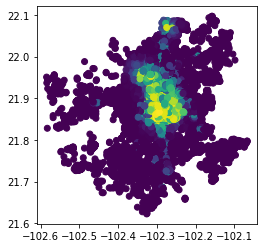

In [21]:
nodes_filter.plot(nodes_filter.ind_accesibilidad)

## Calculating index for hex_bins

### Index by averaging nodes

In [24]:
nodes_hex = gpd.sjoin(nodes_filter, hex_bins, how='left')
print(nodes_hex.shape)
nodes_hex.head(2)

(49086, 17)


,osmid,x,y,geometry,dist_farmacia_left,dist_hospitales_left,dist_supermercados_left,ind_hospitales,ind_supermercado,ind_farmacias,ind_accesibilidad,index_right,hex_id_8,CVEGEO,dist_farmacia_right,dist_hospitales_right,dist_supermercados_right
0,272921360,-102.295073,21.872876,POINT (-102.29507 21.87288),334.213,716.149,232.373,0.924775,0.93225,0.878941,0.911955,69.0,88498e3651fffff,01001,232.850842,1064.353006,211.568228
1,272921393,-102.295097,21.871411,POINT (-102.29510 21.87141),183.576,553.205,71.637,0.936319,0.97419,0.949219,0.953238,69.0,88498e3651fffff,01001,232.850842,1064.353006,211.568228


In [27]:
nodes_hex_mean = nodes_hex.groupby('hex_id_8').mean()
print(nodes_hex_mean.shape)
nodes_hex_mean.head(2)

(1292, 14)


,osmid,x,y,dist_farmacia_left,dist_hospitales_left,dist_supermercados_left,ind_hospitales,ind_supermercado,ind_farmacias,ind_accesibilidad,index_right,dist_farmacia_right,dist_hospitales_right,dist_supermercados_right
hex_id_8,,,,,,,,,,,,,,
884988c043fffff,8.716954e+09,-102.565314,21.955261,10000.0,30578.07125,10000.0,7.012408e-14,3.221894e-26,3.221894e-26,2.335132e-14,562.0,30126.00425,30578.07125,18085.61425
884988c049fffff,5.970865e+09,-102.557947,21.939218,10000.0,28264.76625,10000.0,9.473915e-13,3.221894e-26,3.221894e-26,3.154814e-13,178.0,27812.69925,28264.76625,15772.30925


### Index calculated for distance in hex_bins

In [54]:
hex_filter = hex_bins.loc[(hex_bins['dist_supermercados'] > 0) &
                        (hex_bins['dist_farmacia'] > 0) &
                        (hex_bins['dist_hospitales'] > 0)].copy()
print(hex_filter.shape)
hex_filter.head(2)

(1295, 6)


,geometry,hex_id_8,CVEGEO,dist_farmacia,dist_hospitales,dist_supermercados
0,"POLYGON ((-102.31192 21.70346, -102.30734 21.7...",88498eae51fffff,01001,6013.578500,17233.993500,5827.3075
3,"POLYGON ((-102.18084 21.81199, -102.18133 21.8...",88498ead37fffff,01001,1088.269125,10992.043813,6437.3300


In [55]:
#removes big distance values to avoid errors
hex_filter['dist_supermercados'] = hex_filter['dist_supermercados'].apply(lambda x: x if x <= 10000 else 10000)
hex_filter['dist_farmacia'] = hex_filter['dist_farmacia'].apply(lambda x: x if x <= 10000 else 10000)

#calculate index
#hospital index
hex_filter['ind_hospitales'] =  hex_filter.apply (lambda row: 1 / (1 + math.exp( 0.00109861 * (row.loc['dist_hospitales'] - 3000 ))), axis=1)
hex_filter['ind_supermercado'] = hex_filter.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['dist_supermercados'] - 650 ))), axis=1)
hex_filter['ind_farmacias'] = hex_filter.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['dist_farmacia'] - 650 ))), axis=1)
hex_filter['ind_accesibilidad'] = hex_filter.apply (lambda row: (0.333*row.loc['ind_supermercado']) + (0.334*row.loc['ind_farmacias']) + (0.333*row.loc['ind_hospitales']), axis=1)

<AxesSubplot:>

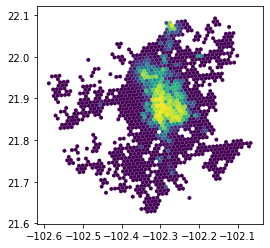

In [56]:
hex_filter.plot(hex_filter['ind_accesibilidad'])

## Comparing index means

#### mean index from distance in nodes

In [29]:
nodes_filter.ind_accesibilidad.mean()

0.4425886174343632

#### mean index by averaging nodes

In [57]:
nodes_hex_mean['ind_accesibilidad'].mean()

0.1185678209627449

#### mean index for distance in hex_bins

In [54]:
hex_filter.ind_accesibilidad.mean()

0.11643512198920729

## Analyzing distribution

#### index from distance in nodes

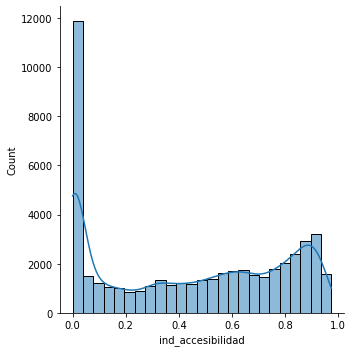

In [41]:
sns.displot(nodes_filter.ind_accesibilidad, kde=True)

#### index by averaging nodes

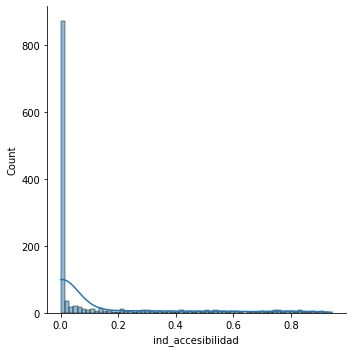

In [42]:
sns.displot(nodes_hex_mean.ind_accesibilidad, kde=True)

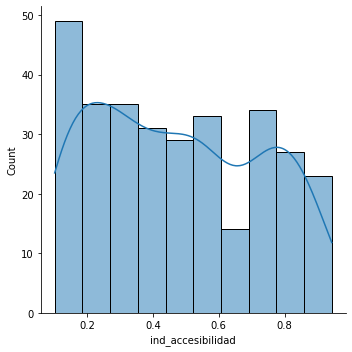

In [53]:
#filtering for values bigger or equal to 0.01
sns.displot(nodes_hex_mean.loc[nodes_hex_mean.ind_accesibilidad>=0.1]['ind_accesibilidad'], kde=True)

#### index using distance in hex_bins

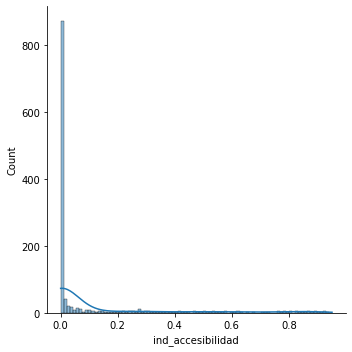

In [59]:
sns.displot(hex_filter.ind_accesibilidad, kde=True)

## weighted accessibility index

In [70]:
nodes_hex_wgt_mean = nodes_hex.groupby('hex_id_8').agg(
                        {'ind_accesibilidad':'mean',
                         'ind_hospitales':'mean',
                         'ind_supermercado':'mean',
                         'ind_farmacias':'mean',
                        'osmid':'count'}).rename(columns={'osmid':'count'})
print(nodes_hex_wgt_mean.shape)
nodes_hex_wgt_mean.head(2)

(1292, 5)


,ind_accesibilidad,ind_hospitales,ind_supermercado,ind_farmacias,count
hex_id_8,,,,,
884988c043fffff,2.335132e-14,7.012408e-14,3.221894e-26,3.221894e-26,4
884988c049fffff,3.154814e-13,9.473915e-13,3.221894e-26,3.221894e-26,4


In [74]:
node_sum = nodes_hex_wgt_mean['count'].sum()

nodes_hex_wgt_mean['w0'] = nodes_hex_wgt_mean.ind_accesibilidad * nodes_hex_wgt_mean['count']

nodes_hex_wgt_mean['ind_acc_media_pond0'] = nodes_hex_wgt_mean.w0 / node_sum

#### weighted index

In [83]:
nodes_hex_wgt_mean['ind_acc_media_pond0'].sum()

0.44330387641081676

In [91]:
hex_ind = pd.merge(nodes_hex_wgt_mean, hex_bins, left_on=nodes_hex_wgt_mean.index,right_on='hex_id_8', how='left')
hex_ind

,ind_accesibilidad,ind_hospitales,ind_supermercado,ind_farmacias,count,w0,ind_acc_media_pond0,geometry,hex_id_8,CVEGEO,dist_farmacia,dist_hospitales,dist_supermercados
0,2.335132e-14,7.012408e-14,3.221894e-26,3.221894e-26,4,9.340527e-14,1.906230e-18,"POLYGON ((-102.56560 21.95137, -102.56050 21.9...",884988c043fffff,01005,30126.004250,30578.071250,18085.614250
1,3.154814e-13,9.473915e-13,3.221894e-26,3.221894e-26,4,1.261925e-12,2.575358e-17,"POLYGON ((-102.56458 21.94096, -102.56407 21.9...",884988c049fffff,01005,27812.699250,28264.766250,15772.309250
2,7.025397e-14,2.109729e-13,3.221894e-26,3.221894e-26,2,1.405079e-13,2.867509e-18,"POLYGON ((-102.56458 21.94096, -102.55999 21.9...",884988c04bfffff,01005,29122.383000,29574.450000,17081.993000
3,7.325637e-13,2.199891e-12,3.221894e-26,3.221894e-26,32,2.344204e-11,4.784089e-16,"POLYGON ((-102.55029 21.94485, -102.55488 21.9...",884988c04dfffff,01005,26993.169750,27445.236750,14952.779750
4,6.527160e-15,1.960108e-14,3.221894e-26,3.221894e-26,1,6.527160e-15,1.332074e-19,"POLYGON ((-102.57989 21.94747, -102.57530 21.9...",884988c059fffff,01005,31278.048000,31730.115000,19237.658000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,2.816913e-06,8.459199e-06,6.610977e-18,6.585875e-24,19,5.352135e-05,1.092272e-09,"POLYGON ((-102.22376 21.75054, -102.21917 21.7...",88498eaf33fffff,01001,9251.093684,13650.354684,7049.787684
1288,1.270356e-08,3.814871e-08,1.201150e-13,3.221894e-26,4,5.081424e-08,1.037025e-12,"POLYGON ((-102.22847 21.69766, -102.22896 21.7...",88498eaf4bfffff,01001,12252.523750,18590.728750,5525.130750
1289,9.614255e-08,2.825162e-07,6.200154e-09,3.221894e-26,1,9.614255e-08,1.962093e-12,"POLYGON ((-102.24521 21.71981, -102.24980 21.7...",88498eaf51fffff,01001,10387.803000,16726.008000,3660.410000
1290,1.154003e-06,7.248455e-07,2.740628e-06,1.248110e-24,2,2.308005e-06,4.710215e-11,"POLYGON ((-102.25488 21.71896, -102.25947 21.7...",88498eaf5bfffff,01001,9564.152500,15902.357500,2836.759500


In [96]:
hex_ind_gdf = gpd.GeoDataFrame(hex_ind)

<AxesSubplot:>

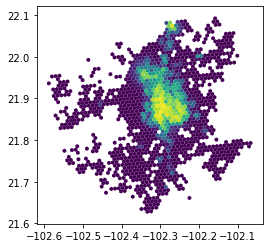

In [97]:
hex_ind_gdf.plot(hex_ind_gdf['ind_accesibilidad'])